<a href="https://colab.research.google.com/github/mforghani775-creator/smart-meter-adoption-analysis-uk/blob/main/Smart_meter_United_Kingdom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Info: Renamed column 'Table 2: Number of domestic smart meters installed by large energy suppliers during each quarter, by fuel type' to 'Quarter' in sheet 'Table2'.
Info: Renamed column 'Table 4: Number of non-domestic smart and advanced meters installed by large energy suppliers during each quarter, by fuel type' to 'Quarter' in sheet 'Table4'.
(52, 42)


/tmp/ipython-input-2740062252.py:155: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["combined_penetration_growth"] = df["combined_smart_penetration"].pct_change()


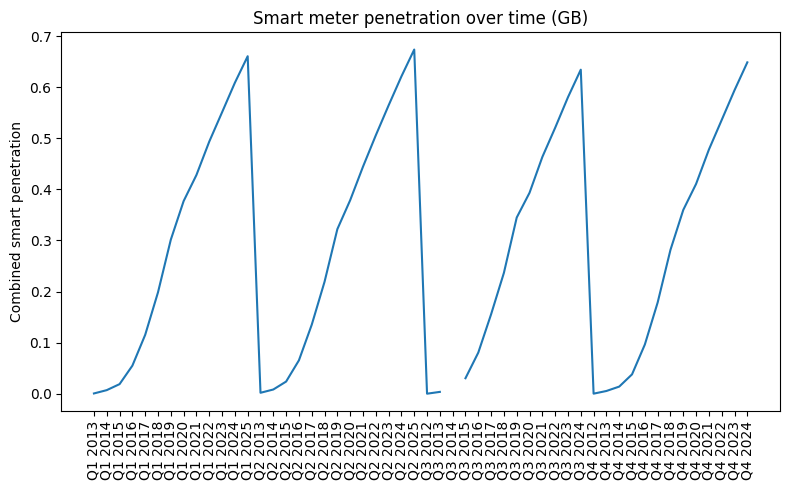

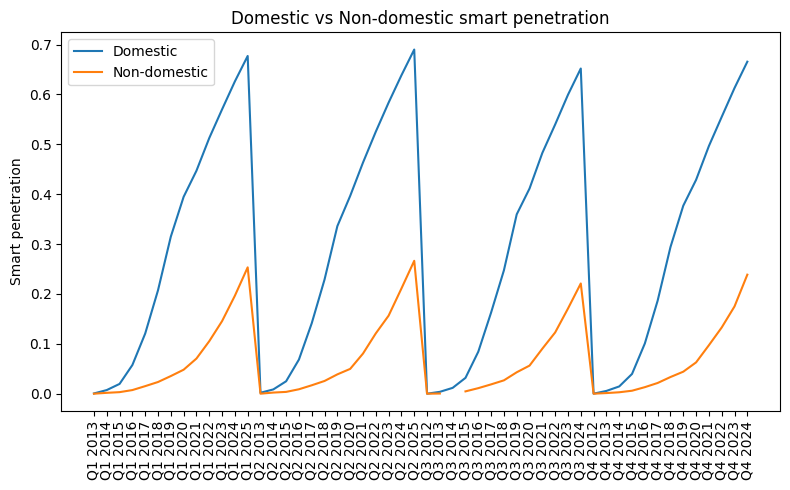

                            dom_total_smart  dom_total_meters  \
dom_total_smart                    1.000000          0.876293   
dom_total_meters                   0.876293          1.000000   
nondom_total_smart                 0.951381          0.939961   
nondom_total_meters               -0.694190         -0.452969   
combined_smart_penetration         0.998436          0.846028   
Year                               0.981970          0.831045   
Quarter_num                       -0.037803         -0.037427   

                            nondom_total_smart  nondom_total_meters  \
dom_total_smart                       0.951381            -0.694190   
dom_total_meters                      0.939961            -0.452969   
nondom_total_smart                    1.000000            -0.663193   
nondom_total_meters                  -0.663193             1.000000   
combined_smart_penetration            0.935281            -0.705805   
Year                                  0.919710       

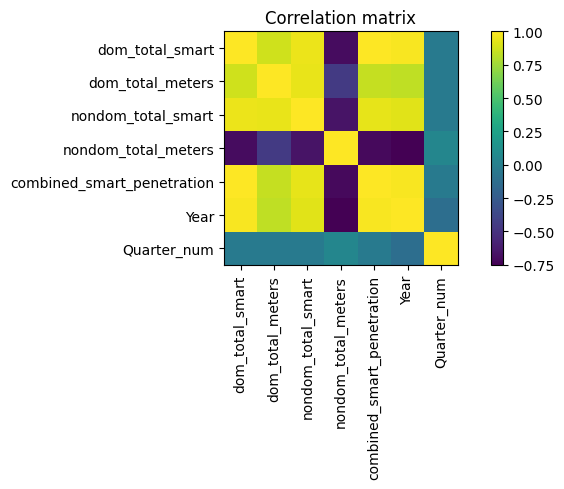

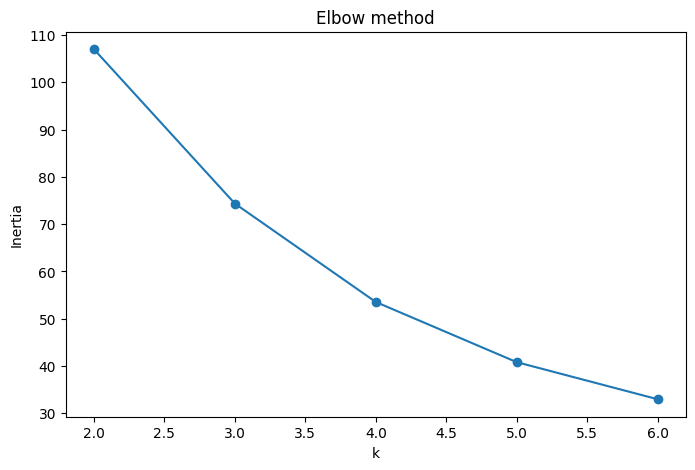

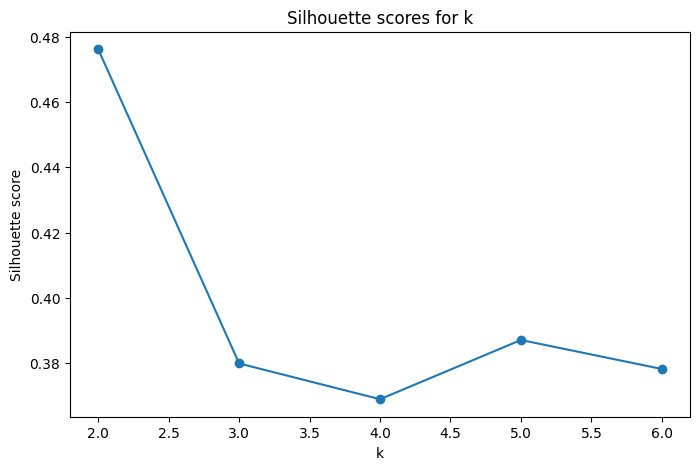

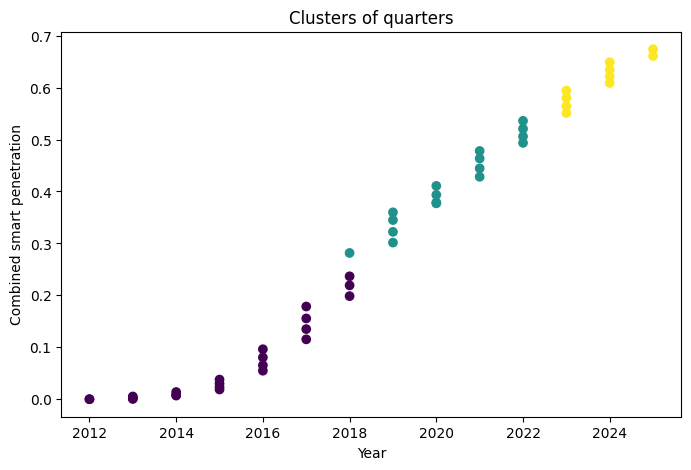

Accuracy: 1.0

Confusion matrix:
 [[5 0 0]
 [0 5 0]
 [0 0 6]]

Classification report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         5
         Low       1.00      1.00      1.00         5
      Medium       1.00      1.00      1.00         6

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



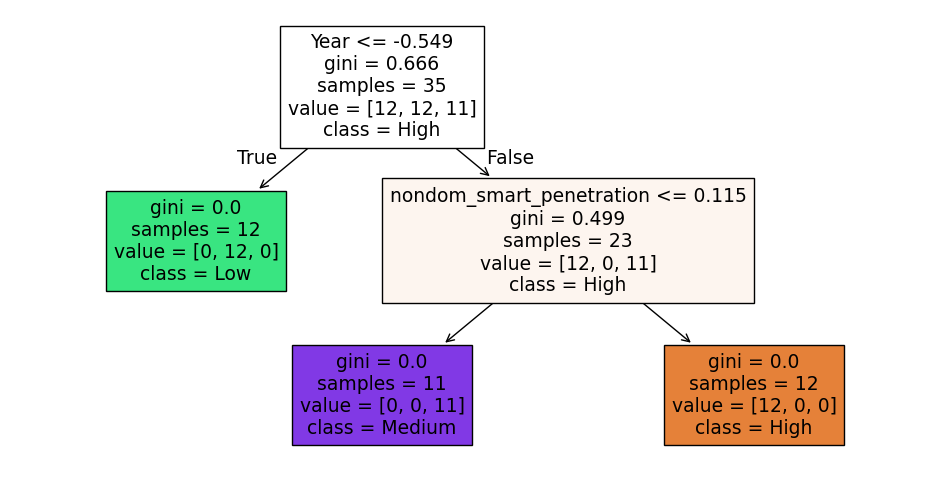

Feature importances:
 Year                             0.507673
nondom_smart_penetration         0.492327
dom_smart_penetration            0.000000
combined_smart_nonsmart_ratio    0.000000
Quarter_num                      0.000000
dtype: float64


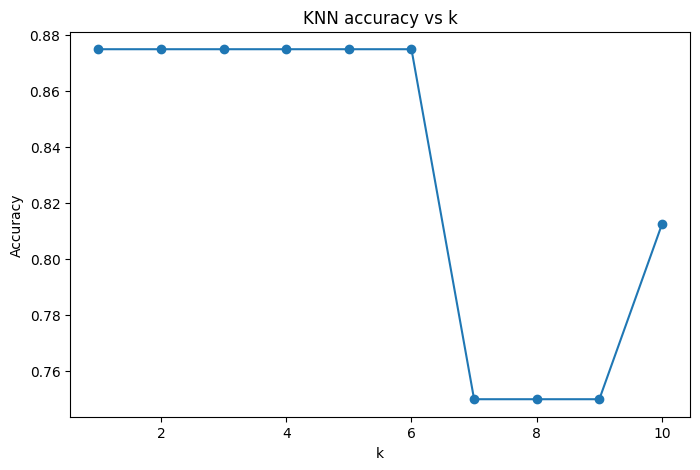

Best k for KNN: 1
KNN accuracy: 0.875
[[4 0 1]
 [0 5 0]
 [0 1 5]]
              precision    recall  f1-score   support

        High       1.00      0.80      0.89         5
         Low       0.83      1.00      0.91         5
      Medium       0.83      0.83      0.83         6

    accuracy                           0.88        16
   macro avg       0.89      0.88      0.88        16
weighted avg       0.89      0.88      0.87        16

Logistic Regression accuracy: 0.8125
[[4 0 1]
 [0 5 0]
 [0 2 4]]
              precision    recall  f1-score   support

        High       1.00      0.80      0.89         5
         Low       0.71      1.00      0.83         5
      Medium       0.80      0.67      0.73         6

    accuracy                           0.81        16
   macro avg       0.84      0.82      0.82        16
weighted avg       0.84      0.81      0.81        16

Logistic regression coefficients:
         dom_smart_penetration  nondom_smart_penetration  \
High         

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


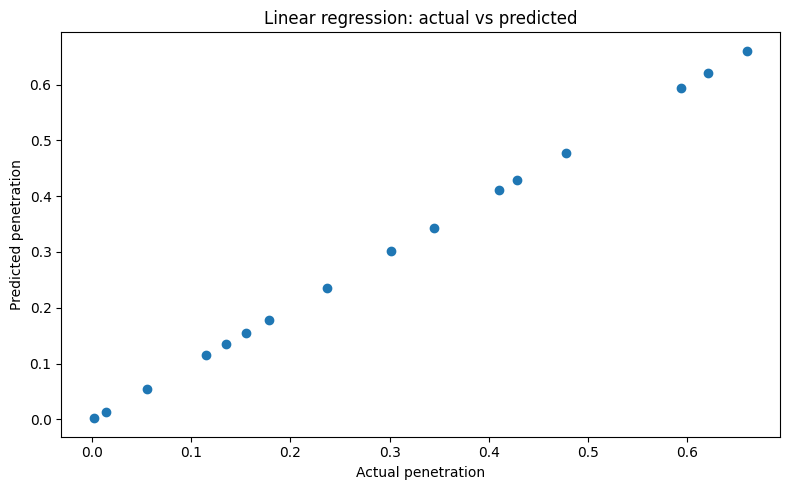

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)

plt.rcParams["figure.figsize"] = (8, 5)

path = "/content/Q2_2025_Smart_Meters_Stats_Tables (1).xlsx"

def load_quarterly_table(sheet_name: str, prefix: str, header_row: int = 7) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet_name, header=header_row)

    df.columns = [str(c).replace("\n", " ").strip() for c in df.columns]


    quarter_col = None
    if "Quarter" in df.columns:
        quarter_col = "Quarter"
    else:

        for col in df.columns:
            if "quarter" in str(col).lower(): # Ensure col is string before lower()
                quarter_col = col
                break
        if quarter_col and quarter_col != "Quarter":

            df = df.rename(columns={quarter_col: "Quarter"})
            print(f"Info: Renamed column '{col}' to 'Quarter' in sheet '{sheet_name}'.")
        elif not quarter_col:
            raise KeyError(f"Column 'Quarter' not found in sheet '{sheet_name}' after cleaning or searching for similar names. Found columns: {df.columns.tolist()}")


    quarter_pattern = r'^Q[1-4]\s\d{4}$'
    df = df[df["Quarter"].astype(str).str.match(quarter_pattern)].copy()


    if "Notes" in df.columns:
        df = df.drop(columns=["Notes"])

    rename = {c: f"{prefix}_{c}" for c in df.columns if c != "Quarter"}
    df = df.rename(columns=rename)
    return df

dom_meters = load_quarterly_table("Table1", "dom")
dom_inst   = load_quarterly_table("Table2", "dom_inst", header_row=0) # Assuming Table2 has headers in the first row
nondom_meters = load_quarterly_table("Table3", "nondom")
nondom_inst   = load_quarterly_table("Table4", "nondom_inst", header_row=0) # Assuming Table4 also has headers in the first row

dom_meters.head()

from functools import reduce

dfs = [dom_meters, dom_inst, nondom_meters, nondom_inst]
df = reduce(lambda left, right: pd.merge(left, right, on="Quarter", how="outer"), dfs)

df = df.sort_values("Quarter").reset_index(drop=True)

print(df.shape)
df.head()

df["Year"] = df["Quarter"].str[-4:].astype(int)
df["Quarter_num"] = df["Quarter"].str[1].astype(int)


def find_col(substring):
    matches = [c for c in df.columns if substring.lower() in c.lower()]
    print(substring, "->", matches)
    return matches

dom_total_smart_col   = [c for c in df.columns if c.startswith("dom_") and "All meters total smart meters" in c][0]
dom_non_smart_col     = [c for c in df.columns if c.startswith("dom_") and "All meters non-smart" in c][0]
dom_total_col         = [c for c in df.columns if c.startswith("dom_") and c.endswith("Total")][0]

nondom_total_smart_col = [c for c in df.columns if c.startswith("nondom_") and "All meters total smart meters" in c][0]
nondom_non_smart_col   = [c for c in df.columns if c.startswith("nondom_") and "All meters non-smart" in c][0]
nondom_total_col       = [c for c in df.columns if c.startswith("nondom_") and c.endswith("Total")][0]


df["dom_total_smart"] = df[dom_total_smart_col]
df["dom_total_nonsmart"] = df[dom_non_smart_col]
df["dom_total_meters"] = df[dom_total_col]
df["dom_smart_penetration"] = df["dom_total_smart"] / df["dom_total_meters"]


df["nondom_total_smart"] = df[nondom_total_smart_col]
df["nondom_total_nonsmart"] = df[nondom_non_smart_col]
df["nondom_total_meters"] = df[nondom_total_col]
df["nondom_smart_penetration"] = df["nondom_total_smart"] / df["nondom_total_meters"]


df["combined_total_smart"] = df["dom_total_smart"] + df["nondom_total_smart"]
df["combined_total_meters"] = df["dom_total_meters"] + df["nondom_total_meters"]
df["combined_smart_penetration"] = df["combined_total_smart"] / df["combined_total_meters"]

df["combined_penetration_growth"] = df["combined_smart_penetration"].pct_change()

# Smart vs non-smart ratio
df["combined_smart_nonsmart_ratio"] = df["combined_total_smart"] / (
    df["dom_total_nonsmart"] + df["nondom_total_nonsmart"]
)

df.head()

plt.plot(df["Quarter"], df["combined_smart_penetration"])
plt.xticks(rotation=90)
plt.ylabel("Combined smart penetration")
plt.title("Smart meter penetration over time (GB)")
plt.tight_layout()
plt.show()

plt.plot(df["Quarter"], df["dom_smart_penetration"], label="Domestic")
plt.plot(df["Quarter"], df["nondom_smart_penetration"], label="Non-domestic")
plt.xticks(rotation=90)
plt.ylabel("Smart penetration")
plt.legend()
plt.title("Domestic vs Non-domestic smart penetration")
plt.tight_layout()
plt.show()

num_features_for_corr = [
    "dom_total_smart", "dom_total_meters",
    "nondom_total_smart", "nondom_total_meters",
    "combined_smart_penetration", "Year", "Quarter_num"
]
corr = df[num_features_for_corr].corr()
print(corr)

plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(num_features_for_corr)), num_features_for_corr, rotation=90)
plt.yticks(range(len(num_features_for_corr)), num_features_for_corr)
plt.colorbar()
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

cluster_features = df[[
    "dom_smart_penetration",
    "nondom_smart_penetration",
    "combined_smart_nonsmart_ratio",
    "Year",
    "Quarter_num",
]].dropna()

scaler = StandardScaler()
X_cluster = scaler.fit_transform(cluster_features)

inertias = []
sil_scores = []
k_values = range(2, 7)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_cluster, labels))

plt.plot(k_values, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.show()

plt.plot(k_values, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores for k")
plt.show()

k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster)

df["cluster"] = -1
df.loc[cluster_features.index, "cluster"] = cluster_labels

df[["Quarter", "dom_smart_penetration", "nondom_smart_penetration",
    "combined_smart_penetration", "cluster"]].head()

plt.scatter(df.loc[cluster_features.index, "Year"],
            df.loc[cluster_features.index, "combined_smart_penetration"],
            c=cluster_labels)
plt.xlabel("Year")
plt.ylabel("Combined smart penetration")
plt.title("Clusters of quarters")
plt.show()

df_clf = df.dropna(subset=["combined_smart_penetration"]).copy()
df_clf["smart_category"] = pd.qcut(
    df_clf["combined_smart_penetration"], 3, labels=["Low", "Medium", "High"]
)

feature_cols = [
    "dom_smart_penetration",
    "nondom_smart_penetration",
    "combined_smart_nonsmart_ratio",
    "Year",
    "Quarter_num",
]
X = df_clf[feature_cols]
y = df_clf["smart_category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_test_scaled = scaler_clf.transform(X_test)

dt = DecisionTreeClassifier(random_state=42, max_depth=4)
dt.fit(X_train_scaled, y_train)

y_pred = dt.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(12, 6))
plot_tree(dt, feature_names=feature_cols, class_names=dt.classes_, filled=True)
plt.show()

feat_imp = pd.Series(dt.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("Feature importances:\n", feat_imp)

k_range = range(1, 11)
knn_acc = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_knn = knn.predict(X_test_scaled)
    knn_acc.append(accuracy_score(y_test, y_knn))

plt.plot(k_range, knn_acc, marker="o")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN accuracy vs k")
plt.show()

best_k = k_range[int(np.argmax(knn_acc))]
print("Best k for KNN:", best_k)

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)
y_knn = knn.predict(X_test_scaled)
print("KNN accuracy:", accuracy_score(y_test, y_knn))
print(confusion_matrix(y_test, y_knn))
print(classification_report(y_test, y_knn))

log_reg = LogisticRegression(max_iter=1000, multi_class="auto")
log_reg.fit(X_train_scaled, y_train)
y_lr = log_reg.predict(X_test_scaled)

print("Logistic Regression accuracy:", accuracy_score(y_test, y_lr))
print(confusion_matrix(y_test, y_lr))
print(classification_report(y_test, y_lr))

coef_df = pd.DataFrame(
    log_reg.coef_,
    columns=feature_cols,
    index=log_reg.classes_
)
print("Logistic regression coefficients:\n", coef_df)

df_reg = df.dropna(subset=["combined_smart_penetration"]).copy()

X_reg = df_reg[feature_cols]  # same predictors
y_reg = df_reg["combined_smart_penetration"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

scaler_reg = StandardScaler()
Xr_train_scaled = scaler_reg.fit_transform(Xr_train)
Xr_test_scaled = scaler_reg.transform(Xr_test)

lin_reg = LinearRegression()
lin_reg.fit(Xr_train_scaled, yr_train)
yr_pred = lin_reg.predict(Xr_test_scaled)

print("R²:", r2_score(yr_test, yr_pred))
print("MAE:", mean_absolute_error(yr_test, yr_pred))
print("MSE:", mean_squared_error(yr_test, yr_pred))
print("RMSE:", np.sqrt(mean_squared_error(yr_test, yr_pred)))

plt.scatter(yr_test, yr_pred)
plt.xlabel("Actual penetration")
plt.ylabel("Predicted penetration")
plt.title("Linear regression: actual vs predicted")
plt.tight_layout()
plt.show()